In [1]:
# General Libraries
import matplotlib.pyplot as plt
%matplotlib widget
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import tqdm
from itertools import accumulate
import utilities
import synchronization_heads.synchronization_utils as synchronization_utils
from synchronization_heads.synchronization import SynchronizationBlock, DesynchronizationBlock
import synchronization_heads.synchronization
from fusing_models.PMCE import PMCE
from fusing_models.RMCE import RMCE

# Reload modules (only when necessary, e.g., during development)
def reload_modules():
    import synchronization_heads.synchronization
    import fusing_models.PMCE
    import fusing_models.RMCE
    import importlib
    importlib.reload(synchronization_heads.synchronization)
    importlib.reload(fusing_models.PMCE)
    importlib.reload(fusing_models.RMCE)
    # Custom Libraries
    import synchronization_heads.synchronization_utils as synchronization_utils
    import utilities
    from synchron_ad import SynchronMaskEstimator
    from synchronization_heads.synchronization import SynchronizationBlock, DesynchronizationBlock
    from fusing_models.PMCE import PMCE
    from fusing_models.RMCE import RMCE


#reload_modules()
# Call reload_modules() only when you need to refresh imports.
# reload_modules()

# Plotting Constants
WIDTH = 12
HEIGHT = 3

In [2]:
MACHINE = 'BrushlessMotor'  # BrushlessMotor, RoboticArm
# Paths to the training and testing HDF5 dataset files
TRAIN_DATASET_PATH = f'data/{MACHINE}/windowed/train_dataset_window_0.100s.h5'
TEST_DATASET_PATH = f'data/{MACHINE}/windowed/test_dataset_window_0.100s.h5'

# List of sensor names to be extracted from the dataset
SENSORS = [
    'imp23absu_mic',
    'ism330dhcx_acc',
    'ism330dhcx_gyro'
]

# List of label names to be extracted from the dataset
LABEL_NAMES = ['segment_id',
               'split_label',
               'anomaly_label',
               'domain_shift_op',
               'domain_shift_env']


PARAMS = {
    'batch_size': 128,
    # TO BE ADAPTED TO YOUR MACHINE: either 'mps or 'cuda' if GPU available,
    # otherwise 'cpu'
    'device': 'mps',
    'patience': 3,
    'normalisation': 'std_window',
    'valid_size': 0.1,
    'seed': 1995,
}


# Load the dataset
X_train_raw, Y_train_raw, X_test, Y_test = utilities.load_dataset(
    TRAIN_DATASET_PATH, TEST_DATASET_PATH, LABEL_NAMES, SENSORS)

# Set the seed for general torch operations
torch.manual_seed(PARAMS['seed'])
# Set the seed for MPS torch operations (ones that happen on the MPS Apple GPU)

if PARAMS['device'] == 'mps':
    torch.mps.manual_seed(PARAMS['seed'])
elif PARAMS['device'] == 'cuda':
    torch.cuda.manual_seed(PARAMS['seed'])
elif PARAMS['device'] == 'cpu':
    torch.manual_seed(PARAMS['seed'])
else:
    raise ValueError(f"Unsupported device type: {PARAMS['device']}")


# Load the dataset
X_train_raw, Y_train_raw, X_test, Y_test = utilities.load_dataset(
    TRAIN_DATASET_PATH, TEST_DATASET_PATH, LABEL_NAMES, SENSORS)

# Combine anomaly labels and domain shift labels to form a combined label
Y_train_raw['combined_label'] = Y_train_raw['anomaly_label'] + \
    Y_train_raw['domain_shift_op'] + Y_train_raw['domain_shift_env']
Y_test['combined_label'] = Y_test['anomaly_label'] + \
    Y_test['domain_shift_op'] + Y_test['domain_shift_env']

# Split training data into training and validation sets, maintaining the
# stratified distribution of the combined label
train_indices, valid_indices, _, _ = train_test_split(
    range(len(Y_train_raw)),
    Y_train_raw,
    stratify=Y_train_raw['combined_label'],
    test_size=PARAMS['valid_size'],
    random_state=PARAMS['seed']
)

# Select the training and validation data based on the indices
X_train = [sensor_data[train_indices] for sensor_data in X_train_raw]
X_valid = [sensor_data[valid_indices] for sensor_data in X_train_raw]
Y_train = Y_train_raw.iloc[train_indices].reset_index(drop=True)
Y_valid = Y_train_raw.iloc[valid_indices].reset_index(drop=True)

# Normalize the training, validation, and test datasets using the
# specified normalization method
X_train, X_valid, X_test = utilities.normalize_data(
    X_train, X_valid, X_test, PARAMS['normalisation'])

# Extract the number of channels and window lengths for each sensor
NUM_CHANNELS = {SENSORS[i]: x.shape[1] for i, x in enumerate(X_train)}
WINDOW_LENGTHS = {SENSORS[i]: x.shape[2] for i, x in enumerate(X_train)}


X_train_tensor = [torch.from_numpy(x) for x in X_train]
X_valid_tensor = [torch.from_numpy(x) for x in X_valid]
X_test_tensor = [torch.from_numpy(x) for x in X_test]

train_dataset = utilities.CustomDataset(X_train_tensor)
valid_dataset = utilities.CustomDataset(X_valid_tensor)
test_dataset = utilities.CustomDataset(X_test_tensor)

train_data_loader = DataLoader(
    train_dataset, batch_size=PARAMS['batch_size'], shuffle=True)
valid_data_loader = DataLoader(
    valid_dataset, batch_size=PARAMS['batch_size'], shuffle=False)
test_data_loader = DataLoader(
    test_dataset, batch_size=PARAMS['batch_size'], shuffle=False)

# Define the lambda parameter
lambda_ = 0.3
sync_head_conv_parameters = synchronization_utils.initialize_parameters(
    SENSORS, WINDOW_LENGTHS, NUM_CHANNELS, lambda_=lambda_)

Skipping ism330dhcx_gyro as it has the same window length as another
Optimum window length: 739, corresponding lambda: 0.3798834818368746
For sensor imp23absu_mic there are 1 solutions
For sensor ism330dhcx_acc there are 716 solutions
For sensor ism330dhcx_gyro there are 716 solutions


# Model Builder

In [3]:
class ModelBuilder:
    def __init__(self, model_params, PARAMS, SENSORS, WINDOW_LENGTHS, NUM_CHANNELS, sync_head_conv_parameters):
        """
        Initializes the model builder with parameters and references.

        Args:
            model_params (dict): Dictionary with model hyperparameters.
            PARAMS (dict): General configuration parameters (device, etc.).
            SENSORS (list): List of sensor names or configurations.
            WINDOW_LENGTHS (list): Window lengths for each sensor type or channel.
            NUM_CHANNELS (list): Number of channels for each sensor.
            sync_head_conv_parameters (dict): Additional params for sync_head_conv if used.
        """
        self.model_params = model_params
        self.PARAMS = PARAMS
        self.SENSORS = SENSORS
        self.WINDOW_LENGTHS = WINDOW_LENGTHS
        self.NUM_CHANNELS = NUM_CHANNELS
        self.sync_head_conv_parameters = sync_head_conv_parameters

    def build_synchronization_block(self):
        """
        Builds and returns a synchronization block based on model_params.
        """
        return SynchronizationBlock(
            params=self.PARAMS,
            sensors=self.SENSORS,
            window_lengths=self.WINDOW_LENGTHS,
            num_channels=self.NUM_CHANNELS,
            c_sync=self.model_params['C_sync'],
            synchronization_method=self.model_params['synchronization_method'],
            fc_num_layers=self.model_params['fc_num_layers'],
            sync_head_conv_parameters=self.sync_head_conv_parameters
        )

    def build_desynchronization_block(self):
        """
        Builds and returns a desynchronization block based on model_params.
        """
        return DesynchronizationBlock(
            params=self.PARAMS,
            sensors=self.SENSORS,
            num_channels=self.NUM_CHANNELS,
            window_lengths=self.WINDOW_LENGTHS,
            c_sync=self.model_params['C_sync'],
            desynchronization_method=self.model_params['desynchronization_method'],
            fc_num_layers=self.model_params['fc_num_layers'],
            sync_head_conv_parameters=self.sync_head_conv_parameters,
        )

    def build_fusing_block(self):
        """
        Builds and returns a fusing block based on model_params.
        """
        return PMCE(
            sensors=self.SENSORS,
            num_channels=self.NUM_CHANNELS,
            c_sync=self.model_params['C_sync'],
            c_fuse=self.model_params['C_fuse'],
            kernel_size=self.model_params['kernel_size']
        )

    def build_all_blocks(self):
        """
        Builds and returns all three blocks as a tuple.
        """
        sync_block = self.build_synchronization_block()
        desync_block = self.build_desynchronization_block()
        fusing_block = self.build_fusing_block()
        return sync_block, desync_block, fusing_block

# Training Sync & Desync Blocks

In [4]:
def train_sync_and_desync_block(
    synchronisation_block,
    desynchronisation_block,
    train_data_loader,
    valid_data_loader,
    epochs=100,
    patience=4,
    lr=0.001,
    verbose=True,
    device='cpu'
):
    """
    Trains the given synchronization and desynchronization blocks 
    using the provided data loaders.

    Args:
        synchronisation_block (nn.Module): The sync block to be trained.
        desynchronisation_block (nn.Module): The desync block to be trained.
        train_data_loader (DataLoader): Dataloader for training data.
        valid_data_loader (DataLoader): Dataloader for validation data.
        epochs (int): Number of training epochs.
        patience (int): Early stopping patience (in epochs).
        lr (float): Learning rate.
        verbose (bool): Prints progress messages if True.
        device (str): Device to place the model and data on. 
                      e.g., 'cuda' or 'cpu'.

    Returns:
        (list, list): (train_losses_epoch, valid_losses_epoch) 
    """
    optimizer = torch.optim.Adam(
        list(synchronisation_block.parameters()) 
        + list(desynchronisation_block.parameters()), lr=lr
    )

    # Move modules to device
    synchronisation_block.to(device)
    desynchronisation_block.to(device)

    best_loss = float('inf')
    non_improving_count = 0
    best_model_state = None

    train_losses_epoch = []
    valid_losses_epoch = []

    # Main loop
    for epoch in range(epochs):
        if verbose:
            print(f"\n----------- Epoch {epoch + 1} -----------")

        # --- Training ---
        synchronisation_block.train()
        desynchronisation_block.train()

        total_train_loss = 0.0
        train_loader_tqdm = tqdm.tqdm(train_data_loader, desc=f"Train Epoch {epoch+1}", leave=True)

        for batch_idx, x_batch in enumerate(train_loader_tqdm):
            x_batch = [x.to(device) for x in x_batch]

            optimizer.zero_grad()

            synced_output = synchronisation_block(x_batch)
            desynced_output = desynchronisation_block(synced_output)

            # Calculate MSE across all sensors
            sensor_losses = torch.cat([
                ((x_in - x_out) ** 2).mean(dim=(0, 2))
                for x_in, x_out in zip(x_batch, desynced_output)
            ])
            loss = sensor_losses.mean()

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            avg_train_loss = total_train_loss / (batch_idx + 1)
            train_loader_tqdm.set_postfix({'Train_loss': avg_train_loss})

        train_losses_epoch.append(avg_train_loss)

        # --- Validation ---
        synchronisation_block.eval()
        desynchronisation_block.eval()

        total_valid_loss = 0.0
        valid_loader_tqdm = tqdm.tqdm(valid_data_loader, desc=f"Valid Epoch {epoch+1}", leave=True)

        with torch.no_grad():
            for batch_idx, x_batch in enumerate(valid_loader_tqdm):
                x_batch = [x.to(device) for x in x_batch]

                synced_output = synchronisation_block(x_batch)
                desynced_output = desynchronisation_block(synced_output)

                sensor_losses = torch.cat([
                    ((x_in - x_out) ** 2).mean(dim=(0, 2))
                    for x_in, x_out in zip(x_batch, desynced_output)
                ])
                loss = sensor_losses.mean()

                total_valid_loss += loss.item()
                avg_val_loss = total_valid_loss / (batch_idx + 1)
                valid_loader_tqdm.set_postfix({'Valid_loss': avg_val_loss})

        valid_losses_epoch.append(avg_val_loss)

        # --- Early Stopping ---
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            non_improving_count = 0
            # Save best state
            best_model_state = {
                'synchronisation_block': synchronisation_block.state_dict(),
                'desynchronisation_block': desynchronisation_block.state_dict(),
                'epoch': epoch + 1,
                'best_loss': best_loss
            }
        else:
            non_improving_count += 1
            if non_improving_count > patience:
                if verbose:
                    print("Stopping early due to no improvement in validation loss.")
                break

    # Load best model if found
    if best_model_state is not None:
        synchronisation_block.load_state_dict(best_model_state['synchronisation_block'])
        desynchronisation_block.load_state_dict(best_model_state['desynchronisation_block'])
        if verbose:
            print(
                f"Loaded best model from epoch {best_model_state['epoch']} "
                f"with val_loss = {best_model_state['best_loss']:.4f}"
            )

    return train_losses_epoch, valid_losses_epoch

# FusionTrainer Class

In [5]:
class FusionTrainer:
    def __init__(
        self,
        synchronisation_block,
        fusing_block,
        desynchronisation_block,
        device,
        lr=1e-4,
        epochs=100,
        train_sync=False
    ):
        """
        Manages training/validation of the fusing block, 
        optionally also trains the synchronization block.

        Args:
            synchronisation_block (nn.Module): Synchronization block.
            fusing_block (nn.Module): Fusion block.
            desynchronisation_block (nn.Module): Desynchronization block.
            device (torch.device): Device (e.g., 'cuda' or 'cpu').
            lr (float): Learning rate.
            epochs (int): Number of epochs.
            train_sync (bool): Whether to train the synchronization block too.
        """
        self.synchronisation_block = synchronisation_block
        self.fusing_block = fusing_block
        self.desynchronisation_block = desynchronisation_block
        self.device = device
        self.lr = lr
        self.epochs = epochs
        self.train_sync = train_sync

        # Always freeze desync block in this scenario, as per your original code:
        freeze_module_parameters(self.desynchronisation_block, freeze=not self.train_sync)

        # Freeze or unfreeze sync block
        freeze_module_parameters(self.synchronisation_block, freeze=not self.train_sync)

        # Move modules to device
        self.synchronisation_block.to(self.device)
        self.fusing_block.to(self.device)
        self.desynchronisation_block.to(self.device)

        # If not training sync, set it to eval mode; otherwise, train mode
        if self.train_sync:
            self.synchronisation_block.train()
            self.desynchronisation_block.train()
        else:
            self.synchronisation_block.eval()

        # Desync always eval in original code
        self.desynchronisation_block.eval()

        # Define optimizer for fusing block (and possibly sync block)
        params_to_optimize = list(self.fusing_block.parameters())
        if self.train_sync:
            params_to_optimize += list(self.synchronisation_block.parameters())

        self.optimizer = torch.optim.Adam(params_to_optimize, lr=self.lr)

        # For logging
        self.train_losses_epoch = []
        self.valid_losses_epoch = []

    def fit(self, train_data_loader, valid_data_loader):
        """
        Trains and validates the fusing block (and optionally the sync block).
        """
        for epoch in range(self.epochs):
            # ---- Training ----
            total_train_loss = 0.0
            train_loader_tqdm = tqdm.tqdm(
                train_data_loader, 
                desc=f"Train Epoch {epoch+1}", 
                leave=True
            )

            self.fusing_block.train()
            if self.train_sync:
                self.synchronisation_block.train()
            else:
                self.synchronisation_block.eval()

            for batch_idx, x_batch in enumerate(train_loader_tqdm):
                x_batch = [x.to(self.device) for x in x_batch]

                self.optimizer.zero_grad()

                # 1) Synchronize
                synched = self.synchronisation_block(x_batch)
                # 2) Fuse
                fused = self.fusing_block(synched)

                if self.train_sync:
                    x_batch_output = self.desynchronisation_block(fused)
                    # Compute reconstruction loss across all sensors
                    sensor_losses = torch.cat([
                        ((x_sensor - x_sensor_out) ** 2).mean(dim=(0, 2))  # (N, C, L) => MSE => (C,) => ...
                        for x_sensor, x_sensor_out in zip(x_batch, x_batch_output)
                    ])
                else:
                    sensor_losses = ((synched - fused)**2).mean(dim=(0, 2))
                
                loss = sensor_losses.mean()

                loss.backward()
                self.optimizer.step()

                total_train_loss += loss.item()
                avg_train_loss = total_train_loss / (batch_idx + 1)
                train_loader_tqdm.set_postfix({'Train_loss': avg_train_loss})

            self.train_losses_epoch.append(avg_train_loss)

            # ---- Validation ----
            total_valid_loss = 0.0
            valid_loader_tqdm = tqdm.tqdm(
                valid_data_loader, 
                desc=f"Valid Epoch {epoch+1}", 
                leave=True
            )

            self.fusing_block.eval()
            self.synchronisation_block.eval()  # Force eval mode for validation

            with torch.no_grad():
                for batch_idx, x_batch in enumerate(valid_loader_tqdm):
                    x_batch = [x.to(self.device) for x in x_batch]

                    synched = self.synchronisation_block(x_batch)
                    fused = self.fusing_block(synched)

                    if self.train_sync:
                        x_batch_output = self.desynchronisation_block(fused)
                        sensor_losses = torch.cat([
                            ((x_sensor - x_sensor_out) ** 2).mean(dim=(0, 2))  # (N, C, L) => MSE => (C,) => ...
                            for x_sensor, x_sensor_out in zip(x_batch, x_batch_output)
                        ])
                    else:
                        sensor_losses = ((synched - fused)**2).mean(dim=(0, 2))
                    loss = sensor_losses.mean()

                    total_valid_loss += loss.item()
                    avg_val_loss = total_valid_loss / (batch_idx + 1)
                    valid_loader_tqdm.set_postfix({'Valid_loss': avg_val_loss})

            self.valid_losses_epoch.append(avg_val_loss)

    def predict(self, data_loader):
        """
        Generates predictions (synced and fused outputs) on new data.
        
        Returns:
            all_synched (torch.Tensor): Concatenated synchronized outputs.
            all_fused   (torch.Tensor): Concatenated fused outputs.
        """
        self.fusing_block.eval()
        self.synchronisation_block.eval()

        all_synched = []
        all_fused = []

        with torch.no_grad():
            for x_batch in tqdm.tqdm(data_loader, desc="Predicting", leave=True):
                x_batch = [x.to(self.device) for x in x_batch]
                synched = self.synchronisation_block(x_batch)
                fused = self.fusing_block(synched)
                all_synched.append(synched)
                all_fused.append(fused)

        # Concatenate across batches
        all_synched = torch.cat(all_synched, dim=0)
        all_fused = torch.cat(all_fused, dim=0)
        return all_synched, all_fused
    
def freeze_module_parameters(module, freeze=True):
    """
    Helper function to freeze or unfreeze parameters in a PyTorch module.
    """
    for param in module.parameters():
        param.requires_grad = not freeze

# Main code

In [24]:
model_params = {
    "synchronization_method": 'sync_head_conv',# 'sync_head_conv', 'sync_head_fc' , 'resample_interp', 'resample_fft', 'zeropad'
    "desynchronization_method": 'conv', # 'conv', 'fc'
    "C_sync": 1,
    "C_fuse": 4,
    "kernel_size": 7,
    "fc_num_layers": 3
}

# ---------------------------------------------------------
# 2. Build models using the ModelBuilder
# ---------------------------------------------------------
builder = ModelBuilder(
    model_params, 
    PARAMS,
    SENSORS,
    WINDOW_LENGTHS,
    NUM_CHANNELS,
    sync_head_conv_parameters
)
synchronisation_block, desynchronisation_block, fusing_block = builder.build_all_blocks()

# ---------------------------------------------------------
# 3. Optionally, train the sync & desync blocks
# ---------------------------------------------------------
if 1:
    train_losses, valid_losses = train_sync_and_desync_block(
        synchronisation_block,
        desynchronisation_block,
        train_data_loader=train_data_loader,
        valid_data_loader=valid_data_loader,
        epochs=15,
        patience=4,
        lr=1e-4,
        verbose=True,
        device=PARAMS['device']
    )

# ---------------------------------------------------------
# 4. Train the fusing block using FusionTrainer
#    (train_sync=False if you don't want to re-train sync)
# ---------------------------------------------------------
trainer = FusionTrainer(
    synchronisation_block=synchronisation_block,
    fusing_block=fusing_block,
    desynchronisation_block=desynchronisation_block,
    device=PARAMS['device'],
    lr=1e-4,
    epochs=25,
    train_sync=False
)

trainer.fit(train_data_loader, valid_data_loader)

# ---------------------------------------------------------
# 5. Predict on new data
# ---------------------------------------------------------
synched_outputs, fused_outputs = trainer.predict(test_data_loader)
print("Synchronized shape:", synched_outputs.shape)
print("Fused shape:", fused_outputs.shape)


----------- Epoch 1 -----------


Valid Epoch 1: 100%|██████████| 52/52 [00:00<00:00, 167.43it/s, Valid_loss=0.897]



----------- Epoch 2 -----------


Valid Epoch 2: 100%|██████████| 52/52 [00:00<00:00, 176.83it/s, Valid_loss=0.712]



----------- Epoch 3 -----------


Valid Epoch 3: 100%|██████████| 52/52 [00:00<00:00, 170.91it/s, Valid_loss=0.578]



----------- Epoch 4 -----------


Valid Epoch 4: 100%|██████████| 52/52 [00:00<00:00, 159.43it/s, Valid_loss=0.495]



----------- Epoch 5 -----------


Valid Epoch 5: 100%|██████████| 52/52 [00:00<00:00, 181.82it/s, Valid_loss=0.427]



----------- Epoch 6 -----------


Valid Epoch 6: 100%|██████████| 52/52 [00:00<00:00, 159.11it/s, Valid_loss=0.364]



----------- Epoch 7 -----------


Valid Epoch 7: 100%|██████████| 52/52 [00:00<00:00, 181.10it/s, Valid_loss=0.318]



----------- Epoch 8 -----------


Valid Epoch 8: 100%|██████████| 52/52 [00:00<00:00, 170.12it/s, Valid_loss=0.292]



----------- Epoch 9 -----------


Valid Epoch 9: 100%|██████████| 52/52 [00:00<00:00, 180.47it/s, Valid_loss=0.276]



----------- Epoch 10 -----------


Valid Epoch 10: 100%|██████████| 52/52 [00:00<00:00, 180.04it/s, Valid_loss=0.264]



----------- Epoch 11 -----------


Valid Epoch 11: 100%|██████████| 52/52 [00:00<00:00, 172.19it/s, Valid_loss=0.251]



----------- Epoch 12 -----------


Valid Epoch 12: 100%|██████████| 52/52 [00:00<00:00, 179.82it/s, Valid_loss=0.239]



----------- Epoch 13 -----------


Valid Epoch 13: 100%|██████████| 52/52 [00:00<00:00, 173.59it/s, Valid_loss=0.23]



----------- Epoch 14 -----------


Valid Epoch 14: 100%|██████████| 52/52 [00:00<00:00, 183.40it/s, Valid_loss=0.223]



----------- Epoch 15 -----------


Valid Epoch 15: 100%|██████████| 52/52 [00:00<00:00, 170.72it/s, Valid_loss=0.216]


Loaded best model from epoch 15 with val_loss = 0.2162


Train Epoch 22:  26%|██▌       | 119/460 [00:05<00:14, 23.16it/s, Train_loss=0.333]


KeyboardInterrupt: 

In [25]:
# ---------------------------------------------------------
# 5. Predict on new data
# ---------------------------------------------------------
synched_outputs, fused_outputs = trainer.predict(test_data_loader)
print("Synchronized shape:", synched_outputs.shape)
print("Fused shape:", fused_outputs.shape)

Predicting: 100%|██████████| 125/125 [00:01<00:00, 72.50it/s]


Synchronized shape: torch.Size([15912, 7, 739])
Fused shape: torch.Size([15912, 7, 739])


In [26]:
import pandas as pd

# Calculate the mean squared error between fused and synchronized outputs
errors_mtx = ((fused_outputs - synched_outputs) ** 2).mean(dim=2).detach().cpu().numpy()  # N, C

# Construct a matrix with proper naming: sensor_name + channel
column_names = [f"{sensor}_{channel}" for sensor in SENSORS for channel in range(NUM_CHANNELS[sensor])]

# Create a DataFrame with the errors
error_df = pd.DataFrame(errors_mtx, columns=column_names)

# Concatenate the error DataFrame with the Y_test DataFrame
Y_test_c = pd.concat([Y_test.copy(), error_df], axis=1)

# Group by segment_id and aggregate the error columns
Y_test_c = utilities.group_by_segment_id(Y_test_c, column_names)
AUC_results = []
for col in column_names:
    AUC = utilities.calculate_single_auc(Y_test_c,col)
    AUC_results.append(AUC)

AUC_results = pd.concat(AUC_results)
AUC_results

,all,source,target
imp23absu_mic_0,0.486234,0.409763,0.531394
ism330dhcx_acc_0,0.569075,0.644149,0.571335
ism330dhcx_acc_1,0.768532,0.970085,0.690828
ism330dhcx_acc_2,0.772313,1.000000,0.647436
ism330dhcx_gyro_0,0.474564,0.674721,0.207101
ism330dhcx_gyro_1,0.330046,0.356345,0.296022
ism330dhcx_gyro_2,0.597469,0.724852,0.523340


Sensor: imp23absu_mic, Losses on channels: 0.398
Sensor: ism330dhcx_acc, Losses on channels: 0.000, 0.163, 0.125
Sensor: ism330dhcx_gyro, Losses on channels: 0.578, 0.901, 0.434


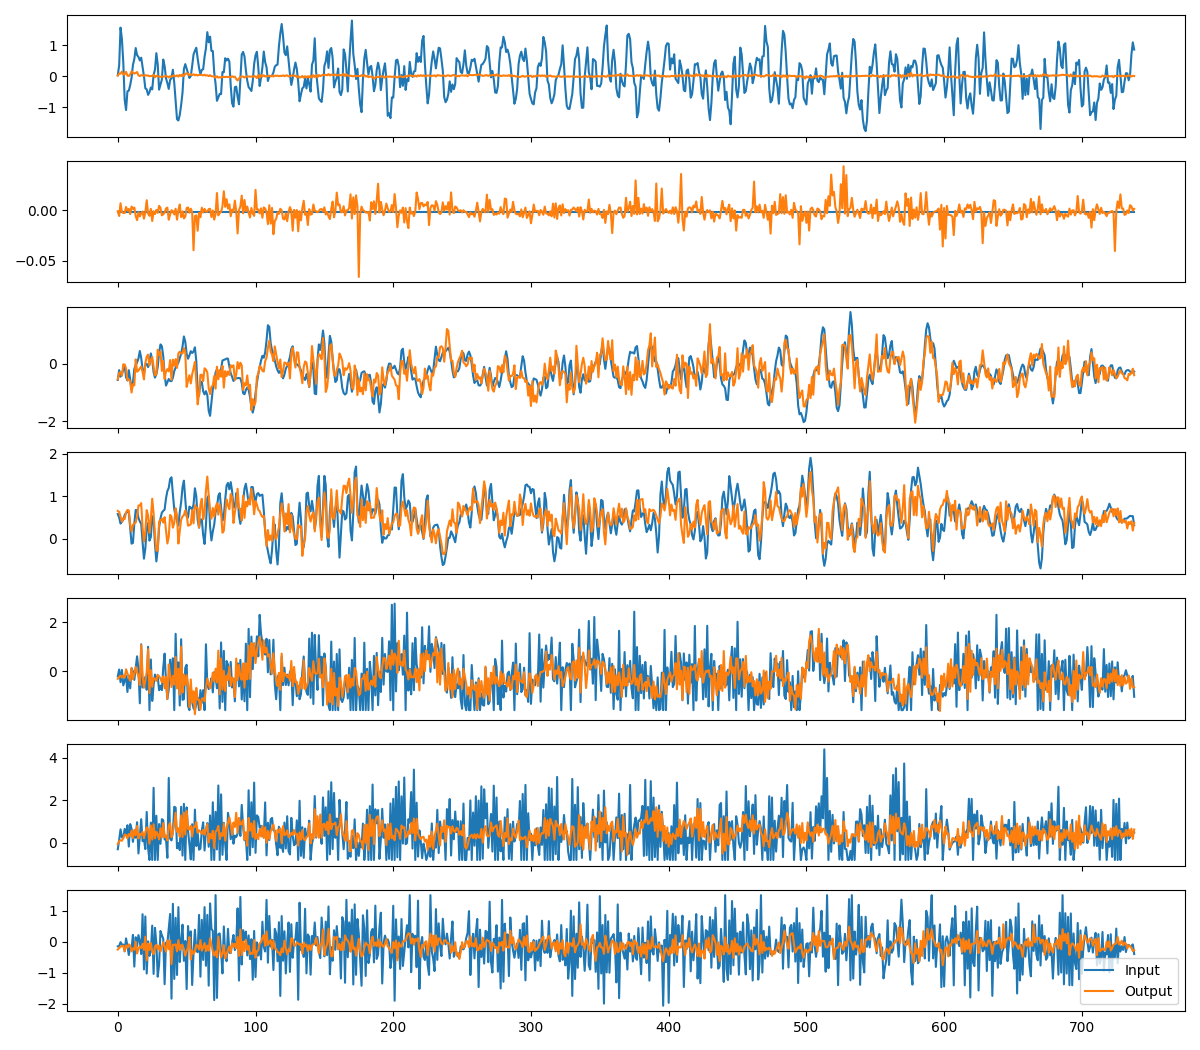

In [27]:
sample = np.random.randint(0, len(test_data_loader.dataset))
inputs = synched_outputs[sample]
outputs = fused_outputs[sample]

total_plot = sum([NUM_CHANNELS[sensor] for sensor in SENSORS])
plt.close('all')
fig, axs = plt.subplots(total_plot, 1, figsize=(
    WIDTH, HEIGHT * total_plot * 0.5), sharex=True)

i = 0
overall_MSE = 0
for sensor_idx, sensor in enumerate(SENSORS):
    sensor_losses = []
    for channel_idx in range(NUM_CHANNELS[sensor]):
        input = inputs[i].cpu().numpy()
        output = outputs[i].detach().cpu().numpy()
        # Calculate loss on output
        loss_output = ((input - output)**2).mean(0)
        sensor_losses.append(f"{loss_output:.3f}")

        axs[i].plot(input, label='Input')
        axs[i].plot(output, label='Output')
        i += 1
        overall_MSE += loss_output
    print(f"Sensor: {sensor}, Losses on channels: {', '.join(sensor_losses)}")

plt.legend()
plt.tight_layout()